# Flood Mapping Example

This notebook provides the code to reproduce the results of the paper for what concerns the flood data.

Due to the size of the data and models it is recommended to run on GPU (cuda).

## 0. Preamble



In [67]:
# import shutil
# import os

# # Delete all files and folders in the current directory
# for item in os.listdir():
#   item_path = os.path.join(os.getcwd(), item)
#   if os.path.isfile(item_path) or os.path.islink(item_path):
#     os.unlink(item_path)  # Remove file or symbolic link
#   elif os.path.isdir(item_path):
#     shutil.rmtree(item_path)  # Remove directory

In [68]:
import os
import subprocess
import shutil

REPO_URL = "https://github.com/FractalySyn/PiNets-Alignment.git"
FOLDER = "floods"

if not os.path.exists(FOLDER) or True:
    subprocess.run(
        ["git", "clone", "--filter=blob:none", "--no-checkout", "--sparse", REPO_URL, "tmp_clone"],
        check=True,
    )
    try:
        subprocess.run(["git", "-C", "tmp_clone", "sparse-checkout", "set", FOLDER], check=True)
        subprocess.run(["git", "-C", "tmp_clone", "checkout", "main"], check=True)
        shutil.copytree(os.path.join("tmp_clone", FOLDER), FOLDER, dirs_exist_ok=True)
    finally:
        shutil.rmtree("tmp_clone", ignore_errors=True)
else:
    print(f"Directory '{FOLDER}' already exists.")

Cloning into 'tmp_clone'...


Your branch is up to date with 'origin/main'.


Already on 'main'


The code chunk below will download the [Sen1Floods11](https://github.com/cloudtostreet/Sen1Floods11) dataset and the [Prithvi foundation model](https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M)

In [69]:
try:
  os.mkdir('floods/external_data/')
  !gsutil -m rsync -r -x ".*(JRCWaterHand|S1OtsuLabelHand|S1Hand).*" gs://sen1floods11/v1.1/data/flood_events/HandLabeled/ floods/external_data/
  !gsutil -m rsync -r gs://sen1floods11/v1.1/splits/flood_handlabeled/ floods/external_data/
  
  os.mkdir('floods/external_data/prithvi/')
  !git clone https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M floods/external_data/prithvi/
  %pip install -q rasterio
  
  print('Done downloading! The data is in the floods/external_data/ directory.')
except:
  print('The floods/external_data/ directory already exists! Skipping download. Verify that the data is present or remove the external_data/ folder and rerun.')

The floods/external_data/ directory already exists! Skipping download. Verify that the data is present or remove the external_data/ folder and rerun.


In [70]:
### Derandomization and determinism setup for reproducibibility
from floods.utils import env_reproducibility
env_reproducibility()

SEED = 2025            ## random seed for reproducibility

### Pytorch engine --- uses GPU (cuda) if available
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Satellite Data



In [71]:
import pandas as pd

DIR = 'floods/external_data/'

## we make our own split so we combine train and val sets here
train_df = pd.read_csv(DIR+'flood_train_data.csv', header=None)
val_df = pd.read_csv(DIR+'flood_valid_data.csv', header=None)
train_df = pd.concat([train_df, val_df], ignore_index=True)
del val_df

test_df = pd.read_csv(DIR+'flood_test_data.csv', header=None)

train_df.head(3)

,0,1
0,Ghana_103272_S1Hand.tif,Ghana_103272_LabelHand.tif
1,Ghana_24858_S1Hand.tif,Ghana_24858_LabelHand.tif
2,Ghana_147015_S1Hand.tif,Ghana_147015_LabelHand.tif


**Example of Sentinel-2 data and flood masks**

In [72]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## plotting setup
colors = ['black', 'lightgray', 'teal']
cmap = mcolors.ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5] 
norm = mcolors.BoundaryNorm(bounds, cmap.N)

**Visualize a sample from the test set**

0       Nigeria_812045_S1Hand.tif
1    Nigeria_812045_LabelHand.tif
Name: 33, dtype: object


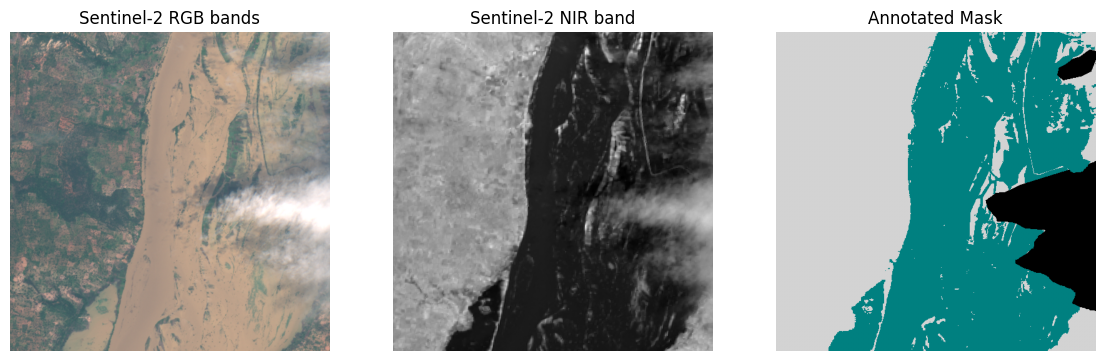

In [73]:
## visualize a sample from the test set
row = test_df.iloc[33]
print(row)

## load Sentinel-2 image and mask
S2_path = DIR+'S2Hand/' + row[0].replace('S1', 'S2')
mask_path = DIR+'LabelHand/' + row[1]
with rasterio.open(S2_path) as src:
  S2 = src.read()
with rasterio.open(mask_path) as src:
  mask = src.read(1)

## preprocess S2 for visualization
S2 = S2 / 3000.0
S2_nir = S2[8]
S2 = S2[[3,2,1]].transpose(1,2,0)

## plot
fig, axs = plt.subplots(1, 3, figsize=(14,5))
[ax.axis('off') for ax in axs]

axs[0].imshow(np.clip(S2, 0.0, 1.0))
axs[1].imshow(S2_nir, cmap='gray')
axs[2].imshow(mask, cmap= cmap, norm=norm);

axs[0].set_title('Sentinel-2 RGB bands')
axs[1].set_title('Sentinel-2 NIR band')
axs[2].set_title('Annotated Mask');

**Load images in memory**

In [74]:
train_df = train_df.sample(50)

In [75]:
import numpy as np
from floods.utils import load_X, load_pi

## load data (images X and masks pi*)
X_train = np.array([load_X(row, DIR) for _, row in train_df.iterrows()])
pi_star_train = np.array([load_pi(row, DIR) for _, row in train_df.iterrows()])

X_test = np.array([load_X(row, DIR) for _, row in test_df.iterrows()])
pi_star_test = np.array([load_pi(row, DIR) for _, row in test_df.iterrows()])

We downsample the 512x512 images and masks into four insets of dimensions 256x256

In [76]:
from floods.utils import split_into_insets, flatten_data, train_val_split, seed_all

X_train_insets = split_into_insets(X_train)  
pi_star_train_insets = split_into_insets(pi_star_train)  
area_train_insets = np.stack([(pi_star_train_insets==k).sum(axis=(2,3)) for k in [-1,0,1]], axis=2)

X_test_insets = split_into_insets(X_test)  
pi_star_test_insets = split_into_insets(pi_star_test)
area_test_insets = np.stack([(pi_star_test_insets==k).sum(axis=(2,3)) for k in [-1,0,1]], axis=2)

In [77]:
## Flatten data
X_train_flat, pi_star_train_flat, area_train_flat = \
  flatten_data(X_train_insets, pi_star_train_insets, area_train_insets)
X_test_flat, pi_star_test_flat, area_test_flat = \
  flatten_data(X_test_insets, pi_star_test_insets, area_test_insets)

# Train/validation split
seed_all(SEED)
X_train_flat, X_val_flat, pi_star_train_flat, pi_star_val_flat, area_train_flat, area_val_flat = \
  train_val_split(X_train_flat, pi_star_train_flat, area_train_flat, val_split=0.2)

# Prepare test scenes for visualization
S2_scenes = X_test_flat[:, [2,1,0]].permute(0,2,3,1).numpy()
S2_scenes = (S2_scenes - S2_scenes.min()) / (S2_scenes.max() - S2_scenes.min()) * (10000 / 3000)

## 2. Training

### 2.1. Hyperparameters 

In [78]:
import json

## Phritvi hyperparameters
with open(DIR+'prithvi/config.json', 'r') as file:
  config = json.load(file)['pretrained_cfg']

## modify config for our use case
config['mask_ratio'] = 0.0
config['img_size'] = 256
config['depth'] = 4

del config['mean'], config['std']
config

{'img_size': 256,
 'patch_size': [1, 16, 16],
 'num_frames': 3,
 'in_chans': 6,
 'embed_dim': 768,
 'depth': 4,
 'num_heads': 12,
 'decoder_embed_dim': 512,
 'decoder_depth': 8,
 'decoder_num_heads': 16,
 'mlp_ratio': 4,
 'mask_ratio': 0.0,
 'bands': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07'],
 'origin_url': 'https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M',
 'paper_ids': 'arXiv:2310.18660'}

In [79]:
BATCH_SIZE = 32        ## batch size for training
N_EPOCHS = 200         ## max training epochs
lr = 5e-3              ## initial learning rate
weight_decay = 5e-3    ## weight decay for optimizer
patience = 1           ## lr scheduler patience
factor = 0.2           ## lr scheduler division factor
ES = 1e-5              ## early stopping - loss threshold

load_pretrained = True   ## whether to load pretrained weights
freeze_encoder = True    ## whether to freeze encoder weights during training








load_pretrained = False   ## whether to load pretrained weights
freeze_encoder = False    ## whether to freeze encoder weights during training


N_EPOCHS = 20         ## max training epochs


In [80]:
os.makedirs('floods/models/', exist_ok=True)

In [81]:
from torch.utils.data import TensorDataset, DataLoader

seed_all(SEED)

## normalization
mu, sigma = X_train_flat.mean(dim=(0,2,3), keepdim=True), X_train_flat.std(dim=(0,2,3), keepdim=True)

## Create DataLoaders for pytorch
train_dataset = TensorDataset((X_train_flat-mu)/sigma, area_train_flat, pi_star_train_flat)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset((X_val_flat-mu)/sigma, area_val_flat, pi_star_val_flat)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset((X_test_flat-mu)/sigma, area_test_flat, pi_star_test_flat)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 2.2. Baseline SegNet

We train the baseline segmentation model with the binary cross entropy loss. Alternatively it can be trained with the false abstraction rate as a loss function. For this set `loss_='FAR'`

In [82]:
from floods.utils import free_ram, model_size
from floods.models import PiPrithvi

free_ram()
seed_all(SEED)

## Initialize Pi-Prithvi model
model = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                  load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
model.to(device)
model_size(model)

## Set loss and optimizer
loss_ = 'BCE' # or FAR
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)

path = 'floods/models/segnet.pt'

Model size: 32.656M parameters


In [83]:
from floods.training import training

## training
model = training(model, train_loader, val_loader, optimizer, scheduler, loss_, N_EPOCHS, device, ES=ES, path=path)

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at /pytorch/aten/src/ATen/native/transformers/cuda/attention_backward.cu:775.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/20, Train Loss: 0.617, Val MAE: 30054, Val TDR: 0.286 Val IoU: 0.086 --- lr: 5.0e-03
Epoch 2/20, Train Loss: 0.540, Val MAE: 26627, Val TDR: 0.297 Val IoU: 0.100 --- lr: 5.0e-03
Epoch 3/20, Train Loss: 0.472, Val MAE: 22768, Val TDR: 0.302 Val IoU: 0.257 --- lr: 5.0e-03
Epoch 4/20, Train Loss: 0.424, Val MAE: 19207, Val TDR: 0.323 Val IoU: 0.317 --- lr: 5.0e-03
Epoch 5/20, Train Loss: 0.383, Val MAE: 15821, Val TDR: 0.337 Val IoU: 0.344 --- lr: 5.0e-03
Epoch 6/20, Train Loss: 0.349, Val MAE: 15020, Val TDR: 0.346 Val IoU: 0.337 --- lr: 5.0e-03
Epoch 7/20, Train Loss: 0.320, Val MAE: 14019, Val TDR: 0.368 Val IoU: 0.327 --- lr: 5.0e-03
Epoch 8/20, Train Loss: 0.300, Val MAE: 10545, Val TDR: 0.365 Val IoU: 0.344 --- lr: 5.0e-03
Epoch 9/20, Train Loss: 0.280, Val MAE: 9629, Val TDR: 0.369 Val IoU: 0.344 --- lr: 5.0e-03
Epoch 10/20, Train Loss: 0.256, Val MAE: 8979, Val TDR: 0.379 Val IoU: 0.353 --- lr: 5.0e-03
Epoch 11/20, Train Loss: 0.247, Val MAE: 9478, Val TDR: 0.374 Val IoU: 

### 2.3. PiNet

We train the PiNet model with the mean absolute error. 

In [84]:
free_ram()
seed_all(SEED)

## Initialize Pi-Prithvi model
model = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                  load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
model.to(device)
model_size(model)

## Set loss and optimizer
loss_ = 'MAE'
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)

path = 'floods/models/pinet.pt'

Model size: 32.656M parameters


In [85]:
## training
model = training(model, train_loader, val_loader, optimizer, scheduler, loss_, N_EPOCHS, device, ES=ES, path=path)

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/20, Train Loss: 23932.388, Val MAE: 25015, Val TDR: 0.294 Val IoU: 0.107 --- lr: 5.0e-03
Epoch 2/20, Train Loss: 21226.098, Val MAE: 24921, Val TDR: 0.288 Val IoU: 0.140 --- lr: 5.0e-03
Epoch 3/20, Train Loss: 18802.989, Val MAE: 20535, Val TDR: 0.283 Val IoU: 0.229 --- lr: 5.0e-03
Epoch 4/20, Train Loss: 16764.521, Val MAE: 16285, Val TDR: 0.297 Val IoU: 0.281 --- lr: 5.0e-03
Epoch 5/20, Train Loss: 15021.756, Val MAE: 15713, Val TDR: 0.302 Val IoU: 0.270 --- lr: 5.0e-03
Epoch 6/20, Train Loss: 13570.201, Val MAE: 11393, Val TDR: 0.308 Val IoU: 0.272 --- lr: 5.0e-03
Epoch 7/20, Train Loss: 12072.848, Val MAE: 12327, Val TDR: 0.309 Val IoU: 0.274 --- lr: 5.0e-03
Epoch 8/20, Train Loss: 11075.662, Val MAE: 10155, Val TDR: 0.329 Val IoU: 0.289 --- lr: 5.0e-03
Epoch 9/20, Train Loss: 10088.292, Val MAE: 12141, Val TDR: 0.330 Val IoU: 0.297 --- lr: 5.0e-03
Epoch 10/20, Train Loss: 8617.389, Val MAE: 8070, Val TDR: 0.345 Val IoU: 0.299 --- lr: 5.0e-03
Epoch 11/20, Train Loss: 7977.3

## 3. Evaluation

In [ ]:
from floods.training import eval

print('--------------------------- SegNet:')
seed_all(SEED)
segnet = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                      load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
segnet.load_state_dict(torch.load(f'floods/models/segnet.pt', map_location=device), strict=False)
pi_test_segnet = eval(segnet, test_loader, device) - 1.0

print('--------------------------- PiNet:')
seed_all(SEED)
pinet = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                      load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
pinet.load_state_dict(torch.load(f'floods/models/pinet.pt', map_location=device), strict=False)
pi_test_pinet = eval(pinet, test_loader, device) - 1.0

--------------------------- SegNet:


RuntimeError: Error(s) in loading state_dict for PiPrithvi:
	Missing key(s) in state_dict: "encoder.cls_token", "encoder.pos_embed", "encoder.patch_embed.proj.weight", "encoder.patch_embed.proj.bias", "encoder.blocks.0.norm1.weight", "encoder.blocks.0.norm1.bias", "encoder.blocks.0.attn.qkv.weight", "encoder.blocks.0.attn.qkv.bias", "encoder.blocks.0.attn.proj.weight", "encoder.blocks.0.attn.proj.bias", "encoder.blocks.0.norm2.weight", "encoder.blocks.0.norm2.bias", "encoder.blocks.0.mlp.fc1.weight", "encoder.blocks.0.mlp.fc1.bias", "encoder.blocks.0.mlp.fc2.weight", "encoder.blocks.0.mlp.fc2.bias", "encoder.blocks.1.norm1.weight", "encoder.blocks.1.norm1.bias", "encoder.blocks.1.attn.qkv.weight", "encoder.blocks.1.attn.qkv.bias", "encoder.blocks.1.attn.proj.weight", "encoder.blocks.1.attn.proj.bias", "encoder.blocks.1.norm2.weight", "encoder.blocks.1.norm2.bias", "encoder.blocks.1.mlp.fc1.weight", "encoder.blocks.1.mlp.fc1.bias", "encoder.blocks.1.mlp.fc2.weight", "encoder.blocks.1.mlp.fc2.bias", "encoder.blocks.2.norm1.weight", "encoder.blocks.2.norm1.bias", "encoder.blocks.2.attn.qkv.weight", "encoder.blocks.2.attn.qkv.bias", "encoder.blocks.2.attn.proj.weight", "encoder.blocks.2.attn.proj.bias", "encoder.blocks.2.norm2.weight", "encoder.blocks.2.norm2.bias", "encoder.blocks.2.mlp.fc1.weight", "encoder.blocks.2.mlp.fc1.bias", "encoder.blocks.2.mlp.fc2.weight", "encoder.blocks.2.mlp.fc2.bias", "encoder.blocks.3.norm1.weight", "encoder.blocks.3.norm1.bias", "encoder.blocks.3.attn.qkv.weight", "encoder.blocks.3.attn.qkv.bias", "encoder.blocks.3.attn.proj.weight", "encoder.blocks.3.attn.proj.bias", "encoder.blocks.3.norm2.weight", "encoder.blocks.3.norm2.bias", "encoder.blocks.3.mlp.fc1.weight", "encoder.blocks.3.mlp.fc1.bias", "encoder.blocks.3.mlp.fc2.weight", "encoder.blocks.3.mlp.fc2.bias", "encoder.norm.weight", "encoder.norm.bias". 

In [94]:
from floods.utils import merge_insets

## prepare images for visualization
pi_test_segnet_insets = pi_test_segnet.reshape(-1, 4, 256, 256).numpy()
pi_test_segnet_merged = merge_insets(pi_test_segnet_insets)

pi_test_pinet_insets = pi_test_pinet.reshape(-1, 4, 256, 256).numpy()
pi_test_pinet_merged = merge_insets(pi_test_pinet_insets)

S2_scenes_insets = S2_scenes.reshape(-1, 4, 256, 256, 3)
S2_scenes_merged = merge_insets(S2_scenes_insets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.23320473730564117..1.2706356048583984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1459701806306839..1.0078892707824707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12824521958827972..1.0325652360916138].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.139714315533638..1.9389704465866089].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1393667757511139..1.7088937759399414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13693393766880035..1.619226336479187].


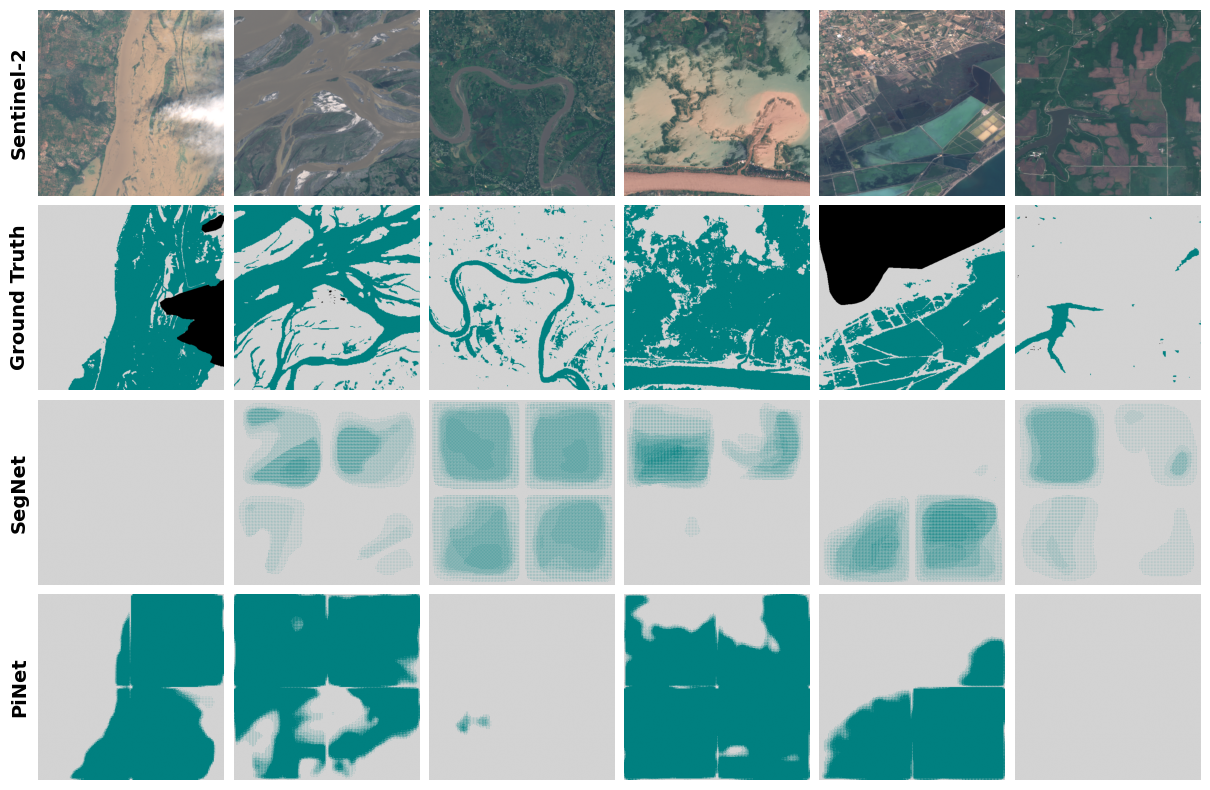

In [95]:
from floods.utils import visualize_predictions

selection = [33, 11, 20, 27, 63, 84]
visualize_predictions(pi_test_segnet_merged, pi_test_pinet_merged, pi_star_test, S2_scenes_merged*2, selection, 
                      names=('SegNet', 'PiNet'), cmap=cmap, norm=norm)

The resulting image is saved as `'floods.png'`

Add
- RETRAIN

Delete
- first cell
- sample (10)
- or True
- otsu

Check
- runs correctly when load_pretrained=False